In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Training import GetDatasets
from Nets  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Simulation import buffer_simulation, save_obj, load_obj


tf.random.set_seed(1234)
np.random.seed(1234)

In [4]:
tf.test.is_gpu_available(True, 2.0)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

a) Get Dataset

In [2]:
train_batch_size = test_batch_size = 32

train_set,valid_set,test_set = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, train_batch_size, test_batch_size)

a) Get Model

In [3]:
import tensorflow_datasets as tfds
tfds.load('colorectal_histology')

{'train': <PrefetchDataset shapes: {filename: (), image: (150, 150, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>}

Se crea la red, sin activar la cuantización ni el efecto de envejecimiento
Las dimensiones de entrada de la imagen (227,227), el número de clases (8) y el tamaño de los batches

In [4]:
AlexNet   = GetNeuralNetworkModel('AlexNet',(227,227,3),8, quantization = False, aging_active=False)
loss      = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
AlexNet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

 b) Load/Save Weigths

In [5]:
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir, 'Weights') 
AlexNet.load_weights(wgt_dir)

Evaluación del accuracy y loss de la red

In [6]:
(OrigLoss,OrigAcc) = AlexNet.evaluate(test_set)
print(test_set)

24/24 [==============================] - 8s 297ms/step - loss: 0.3156 - accuracy: 0.8853
<BatchDataset shapes: ((None, 227, 227, 3), (None, 8)), types: (tf.float32, tf.float32)>


2) Stats

 Write/Read Stats¶

Se identifican (manualmente) las capas procesadadas(Convoluciones, Full conectadas y Pooling) junto a las capas que contienen los resultados que se escribiran en el buffer (capas luego de la funcion de activacion y/o Normalizacion)

In [197]:
for index,layer in enumerate(AlexNet.layers):
    print(index,layer.name)
print('Las capas 0,3,9,11,17,19,25,31,37,40,45 y 50  contienen la informacion para su procesamiento en MMU')
print('Las capas 2,8,10,16,18,24,30,36,38,44,49 y 53 contienen las activaciones que son escritas en memoria')

0 input_2
1 lambda_26
2 lambda_27
3 Conv1
4 lambda_28
5 re_lu_7
6 batch_normalization_5
7 lambda_29
8 lambda_30
9 max_pooling2d_3
10 lambda_31
11 Conv2
12 lambda_32
13 re_lu_8
14 batch_normalization_6
15 lambda_33
16 lambda_34
17 max_pooling2d_4
18 lambda_35
19 Conv3
20 lambda_36
21 re_lu_9
22 batch_normalization_7
23 lambda_37
24 lambda_38
25 Conv4
26 lambda_39
27 re_lu_10
28 batch_normalization_8
29 lambda_40
30 lambda_41
31 Conv5
32 lambda_42
33 re_lu_11
34 batch_normalization_9
35 lambda_43
36 lambda_44
37 max_pooling2d_5
38 lambda_45
39 flatten_1
40 dense_3
41 lambda_46
42 re_lu_12
43 dropout_2
44 lambda_47
45 dense_4
46 lambda_48
47 re_lu_13
48 dropout_3
49 lambda_49
50 dense_5
51 lambda_50
52 tf.compat.v1.nn.softmax_1
53 lambda_51
Las capas 0,3,9,11,17,19,25,31,37,40,45 y 50  contienen la informacion para su procesamiento en MMU
Las capas 2,8,10,16,18,24,30,36,38,44,49 y 53 contienen las activaciones que son escritas en memoria


Con el siguiente bloque obtenemos el número de lecturas y escrituras por posición de memoria tanto usando la estrategia de CNN Gating o sin usarla

In [13]:
num_address  = 290400
Indices      = [0,3,9,11,17,19,25,31,37,40,45,50]
samples      = 2
# Sin Power Gating:
Data         = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=False)
stats        = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
# Con Power Gating
Data     = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
CNN_gating_Acceses = pd.DataFrame(stats).reset_index(drop=False)
#save_obj(Data,'Data/Acceses/AlexNet/Colorectal_Dataset/Baseline')
#save_obj(stats,'Data/Acceses/AlexNet/Colorectal_Dataset/CNN_gating_Adj')

Buffer Simulation

simulación del comportamiento de 1 buffer durante la inferencia de 3 imagenes (solo 3 como ejemplo), la red se crea
 activando la cuantizacion pero no el envejecimiento. LI y AI son los definidos en el item 2) Stats

Como resultado tenemos los siguientes dataframes
.Baseline_Acceses
.CNN_gating_Acceses

............Analizar que hacer con ellos qu infoemación valiosa me brindan

3) Quantization
Ver como afecta la cuantización, tanto en pesos como en activaciones a la accuracy y loss

  ..............a) Number of bits analysis   Poner codigo para cargar los ficheros cuantizados

 b) Used Config

 En base a lo anterior parece prudente usar 11 bits de fracción junto a 4 bits de parte entera tanto para pesos como activaciones, los resultados bajo esa configuracion se pueden obtener usando la función CheckAccurucyAndLoss()

Analizar la posibilidad de usar menos bits

In [11]:
CheckAccuracyAndLoss('AlexNet', test_set, wgt_dir, act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4, 
                    input_shape = (227,227,3), output_shape = 8, batch_size = test_batch_size);

24/24 [==============================] - 16s 644ms/step - loss: 0.3125 - accuracy: 0.8907


 c) Activation Stats

Para la configuración anterior, se observa el valor medio,maximo,minimo y el ratio de saturación tanto de las activaciones procesadas dentro de la unidad matricial de multiplicacion como de las almacenadas en el buffer. Nota: el ultimo parametro indica el numero de iteraciones que se deben realizar hasta agotar el dataset, se obtiene como numero de imagenes del dataset dividido en el batch size.

In [12]:
ActivationStats(AlexNet,test_set,11,4,24)

mean value (MMU): -0.18011768
mean value (Buffer): 0.13878344
maximum (MMU): 45.118935
minimum (MMU): -76.98705
maximum (Buffer): 44.172142
minimum (Buffer): -3.4607625
saturation ratio (MMU): 0.002840600757529724
saturation ratio (Buffer): 7.009283344612763e-06


3) Buffer Simulation

 a) Baseline

Ahora para el Baseline simularemos el comportamiento de 1 buffer durante la inferencia de 3 imagenes (solo 3 como ejemplo), la red se crea ahora activando la cuantizacion pero no el envejecimiento. LI y AI son los definidos en el item 2) Stats

......estos ficheros ya están , solo cargar e interpretarlos

Sin inyectar errores original

In [38]:
## from copy import deepcopy
#from Stats import CheckAccuracyAndLoss
#from Simulation import save_obj, load_obj
#from datetime import datetime
#import itertools
#from Training import GetDatasets
#import numpy as np
#import os
#
#cwd = os.getcwd()
#wgt_dir = os.path.join(cwd, 'Data')
#wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
#wgt_dir = os.path.join(wgt_dir, 'AlexNet')
#wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
#wgt_dir = os.path.join(wgt_dir,'Weights')
#    
#
#trainBatchSize = testBatchSize = 16
#_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)
#
#
#
## Porciones del buffer  a probar
#Accs     = {0.0:[],0.00001:[],0.00005:[],0.0001:[],0.1:[]}
#Loss     = {0.0:[],0.00001:[],0.00005:[],0.0001:[],0.1:[]}
#
#
#network_size   = 290400*16   # Tamaño del buffer (en bits)
#num_of_samples = 10       # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
#for Enumber in Accs:
#    print(Enumber)
#    n_bits_total = np.ceil(network_size).astype(int)    #numero de bits totales
#    print(n_bits_total)
#    buffer = np.array(['0']*(network_size))
#    print(buffer)
#    for index in range(0,num_of_samples):
#        
#        loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
#                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
#                                            batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = False)
#       
#        print(Enumber)
#        print(acc)
#        print(loss)
#      
#        
#        Accs[Enumber].append(acc)
#        Loss[Enumber].append(loss)
#print(str(n_bits_total)+' completada: ', datetime.now().strftime("%H:%M:%S"))
#save_obj(Accs,'Data/Errors/AlexNet/Colorectal Dataset/Accs')
#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

In [32]:
print(load_file('Data/Fault Characterization/wgt/Accs_w_707_55'))
#save_file(Accs,'Data/Fault Characterization/Accs')

[0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8866666555404663, 0.8866666555404663, 0.8866666555404663, 0.8866666555404663, 0.8866666555404663, 0.8880000114440918, 0.8893333077430725, 0.8880000114440918, 0.8893333077430725, 0.8880000114440918]


# Tareas pendientes

## 1- Probar con otros ficheros en alexnet con los demás ficheros(colocando 1 y sacar el acc)
## ok2- ok-Analizar los cambios en los valores con todo 0 , todo 1 y la media de o y 1. 
## ok 2.1- graficar eje x los voltajes, eje y los accurancy y representar los para cuando se coloca todo en 0, todo en 1 y malores medios.
## 3- Probar con otras redes de la tabla del articulo 
## 4-tipos de datos  para los pesos y activaciones , que mapa de errores utiliza para los pesos , para los pesos que coja otra parte del mapa de errores(weights_faults = False,)
# ok2.1.1.Analizar la función la semilla, para que los 1 y o aleatorios siempre sean iguales
# 5- extras mios: probar hacer un mapa de calor de los buffer segun las variantes
# ok.Normalizar la gráfica teniendo en cuenta el original

# Analizando el fichero en su estado original

In [220]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

import csv
import os, sys

 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs = []
Accs_w=[]
#network_size   = 16777216   # Tamaño del buffer (en bits)
#headers=["ceros_a","uno_a","ce_un_a"]

    #num_of_samples = 1      # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss


buffer= (analize_file(('Data/Fault Characterization/KC705_B/RowData/KC705B-0.56.bin'), 16777216))


for index in range(0,num_of_samples):
    
    address_with_errors = np.reshape(buffer,(-1,16))    
    address_with_errors = ["".join(i) for i in address_with_errors[0:1000]]
        #print(address_with_errors)
        
    error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]  
        
        #print(error_mask)
    locs = [x for x,y in enumerate(address_with_errors) if y.count('x') < 1]
  
   
    del address_with_errors
           
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                                act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                                batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
                                                faulty_addresses = locs, masked_faults = error_mask)
    
    loss,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                                act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                                batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
                                                faulty_addresses = locs, masked_faults = error_mask)
    Accs.append(acc)
    Accs_w.append(acc_w)

df = pd.DataFrame(columns=['Acc', 'a_w'])
Acc=pd.DataFrame(Accs)
a_w =pd.DataFrame(Accs_w)


#df.append(pd.DataFrame(Acc, columns=['Acc'] ))
#df.append (pd.DataFrame(a_w, columns=['a_w'] ))

ff3 = pd.concat([Acc,a_w], axis=1, join='outer')

#Acc = Acc.set_index('Acc')




Acc.head()

print()
    
#Accs= df.append(pd.DataFrame(acc, columns=['Accs'] ))
#a_w= df.append (pd.DataFrame(acc_w, columns=['a_w'] ))

#Acc=pd.DataFrame([0.7,0.6,0.5,0.4,0.3,0.2,0.1])
#a_w =pd.DataFrame([0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7])
    
#fv = pd.concat([Accs,a_w], axis=1, join='outer')
#Accs.head() 
      
    
    #archivo = open("fsiete.csv", "w")
    ##titulor= ´""
    #archivo.write(str("acc"))
    #archivo.write(";")
    #archivo.close()
    #   
Accs.append(acc)
    
print(Accs)    
    
        
    
    #Loss[Enumber].append(loss)
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#save_file(Accs,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Cantidad de errores de todo el fihero: 62
Cantidad de elementos por tipo : Counter({'x': 14581698, '0': 62})
Cantidad de elementos por tipo : Counter({'x': 16777144, '0': 72})
16777216

[0.890666663646698, 0.890666663646698]
 operación completada:  16:06:28


In [222]:
ff3

,0,0
0,0.890667,0.890667


# inyectar errores en pesos y activaciones 

In [7]:
## from copy import deepcopy
from Stats import CheckAccuracyAndLoss, CheckAccuracyAndLossPa
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
#from funciones import buffer_vectores, buffer_act_pes
from funciones import buffer_pa
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

import os, sys

 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs = []
Accs_w = []
Accs_a_w = []



#buffer_size= 16777216*16
buffer_size= 10000


       
ruta_bin = 'Data\Fault Characterization\VC707\RawData'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/'
directorio = pathlib.Path(ruta_bin)
num_of_samples = 1


ficheros = [fichero.name for fichero in directorio.iterdir()]
ficheros.sort()

for index in range(0,num_of_samples):
    
    for i, j in enumerate(ficheros):
        print(ficheros)
        
        directorio= os.path.join(ruta_bin, j)
        print(directorio)
        
        buffer= (analize_file(directorio, buffer_size))
        print(buffer)
        error_mask_pa, locs_pa = (buffer_pa(buffer,buffer_size))
    
    loss,acc   = CheckAccuracyAndLossPa('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = True,
                                            faulty_addresses_pa = locs_pa, masked_faults_pa = error_mask_pa)
    
    #loss,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
    #                                    act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
    #                                    batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
    #                                    faulty_addresses = locs, masked_faults = error_mask)
   #
    #loss,acc_a_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
    #                                    act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
    #                                    batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
    #                                    faulty_addresses = locs, masked_faults = error_mask)
    #
    
    
    Accs.append(acc)
    #Accs_w.append(acc_w)
    #Accs_a_w.append(acc_a_w)                                      
    print(Accs)
arqui=pd.DataFrame(ficheros)
Acc=pd.DataFrame(Accs)
#Acc_w =pd.DataFrame(Accs_w)
#Acc_a_w =pd.DataFrame(Accs_w)                                         
#buf_cero = pd.concat([arqui,Acc,Acc_w, Acc_a_w], axis=1, join='outer')
#buf_cero.columns =['arqui','Acc_cero', 'A_w_cero', 'Acc_a_w_cero'] 
#buf_cero.to_excel('resultado.xlsx', sheet_name='ceros_707', index=False)
#

Acc.head()
    
   



    
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#lsave_file(Accs,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.54.bin
['x' 'x' 'x' ... 'x' 'x' 'x']
estoy aqi
error_mask_activ []
locs_act []
error_mask_pesos: []
locs_p []
10000
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.55.bin
['x' 'x' 'x' ... 'x' 'x' 'x']
estoy aqi
error_mask_activ []
locs_act []
error_mask_pesos: []
locs_p []
10000
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.56.bin
['x' 'x' 'x' ... 'x' 'x' 'x']
estoy aqi
error_mask_activ []
locs_act []
error_mask_pesos: []
locs_p []
10000
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.

Cambio del código preliminar

In [10]:
## from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs = []
Acc_w = []
Acc_a_w = []

df = pd.DataFrame(columns=['Accs', 'Acc_w'])
buffer_size= 16777216

       
ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/'
directorio = pathlib.Path(ruta_bin)

variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]

for i, j in enumerate(ficheros):
    directorio= os.path.join(ruta_bin, j)
    print(directorio)
    
    buffer= (analize_file(directorio, buffer_size))
    print(buffer)
    error_mask, locs = (buffer_vectores(buffer))
    print('buffer despues de analize_file :', collections.Counter(buffer))
    print(error_mask)
    print(locs)
    
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
    loss,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
    loss,acc_a_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = True,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
    
    Accs.append(acc)
    Accs_w.append(acc_w)
    Acc_a_w.append(acc_a_w)                                      

df = pd.DataFrame(columns=['Acc', 'a_w', 'acc_a_w'])
Acc=pd.DataFrame(Accs)
a_w =pd.DataFrame(Accs_w)
acc_a_w =pd.DataFrame(Accs_w)                                         
buf_cero = pd.concat([Acc,A_w, acc_a_w], axis=1, join='outer')
buf_cero.columns =['Acc_cero', 'A_w_cero', 'Acc_a_w'] 
buf_cero.to_excel('resultado.xlsx', sheet_name='ceros', index=False)


Acc.head()
    
   



    
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_file(Accs,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Data/Fault Characterization/KC705_B/RowData/KC705B-0.53.bin
(array(['x', 'x', 'x', ..., 'x', 'x', 'x'], dtype='<U11'), Counter({'x': 16774576, '0': 2640}), 2274)


C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: cannot reshape array of size 3 into shape (16)

In [4]:
ff3


NameError: name 'ff3' is not defined

In [236]:

ff3.to_excel('sample_data.xlsx', sheet_name='ceros', index=False)

In [76]:
Accs
headers=["ceros_a","uno_a","ce_un_a"]    
with open(f"fsiete.csv", 'w', newline='') as file:
    writer = csv.writer(file, delimiter=",",quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(headers)
    writer.writerow(Accs)
        

In [37]:
import pandas as pd
df = pd.DataFrame(columns=['Acc', 'a_w'])

Acc=pd.DataFrame([0.7,0.6,0.5,0.4,0.3,0.2,0.1])
a_w =pd.DataFrame([0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7])
a_w_p =pd.DataFrame([0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7])


#df.append(pd.DataFrame(Acc, columns=['Acc'] ))
#df.append (pd.DataFrame(a_w, columns=['a_w'] ))

ff3 = pd.concat([Acc,a_w,a_w_p], axis=1, join='outer')
ff3.columns =['Name', 'Code', 'Age'] 

#Acc = Acc.set_index('Acc')




ff3.head()

print(ff3)

   Name  Code  Age
0   0.7   0.1  0.1
1   0.6   0.2  0.2
2   0.5   0.3  0.3
3   0.4   0.4  0.4
4   0.3   0.5  0.5
5   0.2   0.6  0.6
6   0.1   0.7  0.7


# De esta forma los datos están mas distibuidos 

In [5]:
from sklearn import preprocessing
datos_min_max = preprocessing.MinMaxScaler().fit_transform(ff3)
print(datos_min_max)





[[1.         0.         0.        ]
 [0.83333333 0.16666667 0.16666667]
 [0.66666667 0.33333333 0.33333333]
 [0.5        0.5        0.5       ]
 [0.33333333 0.66666667 0.66666667]
 [0.16666667 0.83333333 0.83333333]
 [0.         1.         1.        ]]


# En este metodo se usa aplica el rango intercuartilico, para que los datos atipicos no afecten el anélisis, se asume que es el más robusto

In [3]:
from sklearn import preprocessing
datos_robust_escaler = preprocessing.RobustScaler().fit_transform(ff3)
print(datos_robust_escaler)


[[ 1.         -1.         -1.        ]
 [ 0.66666667 -0.66666667 -0.66666667]
 [ 0.33333333 -0.33333333 -0.33333333]
 [ 0.          0.          0.        ]
 [-0.33333333  0.33333333  0.33333333]
 [-0.66666667  0.66666667  0.66666667]
 [-1.          1.          1.        ]]


# normalizar (no e slo mismo que estandarizar) 
para esto se larga la magnitud del vector para que los valores esten entre 0 y uno, para garantizar que ningun elemento tenga una magnitud mayor a la que tendria todo el lemento, norma del vector , cada valor se divide entre la sumatoria de todos los valores al cuadrado

In [38]:
from sklearn import preprocessing
datos_normalizer = preprocessing.Normalizer().transform(ff3.T)
datos_normalizer = datos_normalizer.T
print(datos_normalizer)

[[0.59160798 0.08451543 0.08451543]
 [0.50709255 0.16903085 0.16903085]
 [0.42257713 0.25354628 0.25354628]
 [0.3380617  0.3380617  0.3380617 ]
 [0.25354628 0.42257713 0.42257713]
 [0.16903085 0.50709255 0.50709255]
 [0.08451543 0.59160798 0.59160798]]


   Name      code       age
0   NaN  0.000000  0.000000
1   NaN  0.166667  0.166667
2   NaN  0.333333  0.333333
3   NaN  0.500000  0.500000
4   NaN  0.666667  0.666667
5   NaN  0.833333  0.833333
6   NaN  1.000000  1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

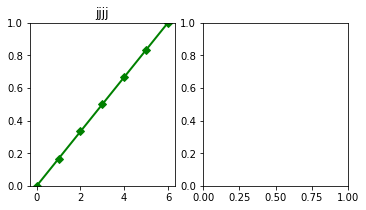

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
datos_min_max = pd.DataFrame(datos_min_max, columns=["Name","code", "age"])
print(datos_min_max)
fig= plt.figure(figsize =(15,3))
ax1 = fig.add_subplot(1,5, 1)
ax1.set_ylim(0,1)
ax2 = fig.add_subplot(1, 5,2)


ax1.set_title("jjjj")
ax1.plot(datos_min_max["code"], color='green', ls='-', lw='2', marker='D', markersize='5')

plt.show


In [6]:
import pandas as pd
df = pd.DataFrame(columns=['Acc', 'a_w'])
Acc=[0.7,0.6,0.5,0.4,0.3,0.2,0.1]
a_w =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7]
    
f = pd.concat([Acc,a_w], axis=1, join='outer')

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

crear excel

In [85]:
from openpyxl import Workbook
from openpyxl import load_workbook
#wb = Workbook()
#wb.save('nuevo.xlsx')
wb2 = load_workbook('prueba.xlsx')
#ws1 = wb2.create_sheet('707')

ws = wb2['707']
wb2.save('prueba.xlsx')

In [ ]:
#headers=["fichero","e_total","e_muestra","e_ceros","e_uno", "0_A",]
#headers=["ceros_a","uno_a","ce_un_a","ceros_p","uno_p","ce_un_p","ceros_a_p","uno_a_p","ce_un_a_p"]
headers=["ceros_a","uno_a","ce_un_a"]

#lista_datos= accs

with open(f"fsiete.csv", 'w', newline='') as file:
    writer = csv.writer(fsiete)
    writer.writerow(headers)
    for j in accs:
        writer.writerow(j)
        
import csv
with open('eggs.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
    spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [267]:
Accs_705_53

NameError: name 'Accs_705_53' is not defined

# prueba inyectando errores en '1'


In [6]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import os
 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)



network_size   = 16777216   # Tamaño del buffer (en bits)


num_of_samples = 10      # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
#buffer= (analize_file_uno(('Data/VC'), network_size))
buffer= (analize_file(('Data/Fault Characterization/KC705_B/RowData/KC705B-0.56'), network_size))
print(len(buffer))


for index in range(0,num_of_samples):
    address_with_errors = np.reshape(buffer,(-1,16))    
    address_with_errors = ["".join(i) for i in address_with_errors[0:network_size]]
    
    error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]  
    
    print((error_mask))
    locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
  
   
    del address_with_errors
           
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
                                 
       
       
             
    Accs.append(acc)
    #Loss[Enumber].append(loss)
    print(loss)
    print(acc)
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#save_obj(Accs,'Data/Fault Characterization/Accs')
#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Cantidad de errores de todo el fihero: 62
Cantidad de elementos por tipo : Counter({'x': 14581698, '0': 62})
Cantidad de elementos por tipo : Counter({'x': 16777144, '0': 72})
16777216
16777216
['xxxxx0xxxxxxx0xx', 'xxxxx0xxxxxxx0xx', 'xxxxx0xxxxxxx0xx', '0xxxxxxx0xxxxxxx', 'xx0xxxxxxx0xxxxx', 'xxxxxxx0xxxxxxx0', 'xxx0xxxxxxx0xxxx', 'xxxxxx0xxxxxxx0x', 'xxxxx0xxxxxxx0xx', 'xxxx0xxxxxxx0xxx', '0xxxxxxx0xxxxxxx', '0xxxxxxx0xxxxxxx', '0xxxxxxx0xxxxxxx', '0xxxxxxx0xxxxxxx', 'x0xxxxxxx0xxxxxx', 'x0xxxxxxx0xxxxxx', 'x0xxxxxxx0xxxxxx', 'xxxxx0xxxxxxx0xx', 'xxxxx0xxxxxxx0xx', '0xxxxxxx0xxxxxxx', '0xxxxxxx0xxxxxxx', 'xxx0xxxxxxx0xxxx', 'xxx0xxxxxxx0xxxx', 'xxx0xxxxxxx0xxxx', 'xxxxxxx0xxxxxxx0', 'xxxx0xxxxxxx0xxx', 'xxxx0xxxxxxx0xxx', 'xx0xxxxxxx0xxxxx', 'xxxxxxx0xxxxxxx0', 'xxxxxxx0xxxxxxx0', '0xxxxxxx0xxxxxxx', 'xxxxx0xxxxxxx0xx', 'xxxxx0xxxxxxx0xx', 'xxxxx0xxxxxxx0xx', '0xxxxxxx0xxxxxxx', 'xx0xxxxxxx0xxxxx']


InvalidArgumentError:  indices[111] = [15, 209, 181, 2] does not index into param shape [14,227,227,3], node name: model/lambda_1/GatherNd
	 [[node model/lambda_1/GatherNd (defined at C:\Users\usuario\Desktop\CNN_Gating\Nets.py:79) ]] [Op:__inference_test_function_2879]

Errors may have originated from an input operation.
Input Source operations connected to node model/lambda_1/GatherNd:
 model/lambda/Maximum (defined at C:\Users\usuario\Desktop\CNN_Gating\Nets.py:54)

Function call stack:
test_function


#  Inyectando errores de forma aleatoria como '0' y '1'

In [48]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import os
import csv
 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)

Accs = []
Accs_w = []



network_size   = 16777216   # Tamaño del buffer (en bits)


num_of_samples = 1      # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss


buffer= (analize_file_uno_ceros(('Data/Fault Characterization/VC707/RawData/VC707-0.55.bin'), network_size))



for index in range(0,num_of_samples):
    address_with_errors = np.reshape(buffer,(-1,16))    
    address_with_errors = ["".join(i) for i in address_with_errors[0:1000]]
    
    error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]  
   
    
    
    #print(len(error_mask))
    locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
  
   
    del address_with_errors
           
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
    loss,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
                                            faulty_addresses = locs, masked_faults = error_mask)
    loss,acc_w_a   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = True,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
    
    Accs.append(acc)
    print(Accs)
headers=["ceros_a","uno_a","ce_un_a"]    
with open(f"fsiete.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    for j in Accs:
        writer.writerow(j)                              
       
       
   # archivo = open("fsiete.csv", "w")
   # #titulor = "a_c_u, p_c_u, pa_c_u\n"
   # archivo.write(str(acc))
   # archivo.write(";")
   # archivo.write(str(acc_w))
   # archivo.write(";") 
   # archivo.write(str(acc_w_a))
   # archivo.write(";")
   # archivo.close()
                
    #Accs.append(acc)
    #Accs.append(acc_w)
    1#Accs.append(acc_w_a)
    #Loss[Enumber].append(loss)
    #print(loss)
    #print(acc)
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#save_obj(Accs,'Data/Fault Characterization/Accs')
#save_obj(Accs_w,'Data/Fault Characterization/Accs_w')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Cantidad de errores de todo el fihero: 7520
Cantidad de elementos por tipo : Counter({'x': 16773858, '1': 1701, '0': 1657})
[0.890666663646698]


Error: iterable expected, not float

In [ ]:
with open(f"fsiete.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    for j in accs:
        writer.writerow(j)
        
import csv
with open('eggs.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
    spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [25]:
Accs

[0.890666663646698, 0.890666663646698, 0.890666663646698]

# Medición para las fallas en los pesos

In [28]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np

import os
 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs_w = []
network_size   = 16777216   # Tamaño del buffer (en bits)


num_of_samples = 2      # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
#f_dir=('Data/Fault Characterization')

buffer= (analize_file_uno(('Data/Fault Characterization/VC707/RawData/VC707-0.55'), network_size))
#buffer= (analize_file((f_dir + VC707/RawData/VC707-0.54), network_size))


for index in range(0,num_of_samples):
    
    address_with_errors = np.reshape(buffer,(-1,16))    
    address_with_errors = ["".join(i) for i in address_with_errors[0:]]
    
    error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]  
    
    #print(error_mask)
    locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
    print(locs)
    
    
    
  
   
    del address_with_errors
           
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
                                            faulty_addresses = locs, masked_faults = error_mask)
   
    
 
      
    
                                 
       
       
             
    Accs_w.append(acc)
    #Loss[Enumber].append(loss)
    print(loss)
    print(acc)
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_file(Accs_w,'Data/Fault Characterization/Accs_w')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Cantidad de errores de todo el fihero: 7520
Cantidad de elementos por tipo : Counter({'x': 16773858, '1': 3358})
[4141, 4181, 4241, 4789, 4899, 4903, 5001, 18073, 18199, 18343, 18355, 18365, 28702, 28894, 29150, 30576, 34604, 34666, 43076, 43658, 43810, 64280, 64428, 68938, 71185, 71189, 71191, 71193, 71209, 71219, 71225, 71229, 71233, 71237, 71239, 71241, 71247, 71257, 71261, 71273, 71275, 71277, 71279, 71281, 71283, 71285, 71287, 71297, 71303, 71305, 71309, 71315, 71321, 71323, 71325, 71327, 71339, 71345, 71347, 71349, 71351, 71359, 71361, 71363, 71365, 71367, 71369, 71371, 71373, 71375, 71377, 71379, 71381, 71383, 71385, 71393, 71401, 71403, 71417, 71421, 71423, 71425, 71429, 71431, 71433, 71435, 71437, 71439, 71441, 71443, 71445, 71447, 71453, 71455, 71465, 71469, 71471, 71473, 71489, 71493, 71495, 71497, 71501, 71513, 71517, 71521, 71529, 71531, 71551, 71561, 71581, 71591, 71609, 71611, 71613, 71615, 71617, 71625, 71627, 71633, 71641, 71657, 71659, 71661, 71663, 71669, 71673, 7335

[]
hola
[]
hola
[]
hola
[]
hola
[]
hola
[]
[]
hola
[]
hola
[]
hola
[]
hola
[]
hola
[]
[]
hola
[]
hola
[]
hola
[]
hola
[]
hola
[]
[]
hola
[]
hola
[]
hola
[]
hola
[]
hola
[]
[]
hola
[]
hola
[]
hola
[]
hola
[]
hola
[]
[[65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 16448], [65535, 8224], [65535, 8224], [65535, 8224], [65535, 16448], [65535, 8224], [65535, 8224], [65535, 2056], [65535, 1028], [65535, 4112], [65535, 16448], [65535, 16448], [65535, 257], [65535, 4112], [65535, 4112], [65535, 6168], [65535, 4112], [65535, 4112], [65535, 2056], [65535, 2056], [65535, 4112], [65535, 2056], [65535, 4112], [65535, 4112], [65535, 4112], [65535, 4112], [65535, 4112], [65535, 4112], [65535, 4112], [65535, 2056], [65535, 4112], [65535, 4112], [65535, 6168], [65535, 2056], [65535, 6682], [65535, 4626], [65535, 4112], [65535, 4112], [65535, 4112], [65535, 4112], [6553

InvalidArgumentError: indices[15] = [7, 238] does not index into param shape [4096,8], node name: GatherNd [Op:GatherNd]

# Inyeccción en los pesos- y activaciones

In [88]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalizeWgt import  analize_file_uno_w,analize_file_uno_ceros_w, save_file, load_file
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import os

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)



network_size   = 16777216*2   # Tamaño del buffer (en bits)


num_of_samples = 5     # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
#buffer= (analize_file_uno_ceros(('Data/VC'), network_size))
buffer= (analize_file_uno_w(('Data/Fault Characterization/VC707/RawData/VC707-0.56'), network_size))


for index in range(0,num_of_samples):
    address_with_errors = np.reshape(buffer,(-1,16))    
    address_with_errors = ["".join(i) for i in address_with_errors[0:]]
    
    error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]  
    
    #print(error_mask)
    locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
  
   
    del address_with_errors
           
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = True ,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
                                 
       
       
             
    Accs_w.append(acc)
    #Loss[Enumber].append(loss)
    print(loss)
    print(acc)
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_obj(Accs_w,'Data/Fault Characterization/Accs_w')


Cantidad de errores de todo el fihero: 2732
Cantidad de elementos por tipo : Counter({'x': 16775646, '1': 1570})


KeyboardInterrupt: 

Pruebas para la otra parte del buffer

In [75]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalizeWgt import analize_file_w, analize_file_uno_w,analize_file_uno_ceros_w, save_file, load_file
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import os
 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

8

for index in range(0,num_of_samples):
    address_with_errors = np.reshape(buffer,(-1,16))    
    address_with_errors = ["".join(i) for i in address_with_errors[0:]]
    
    error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]  
   
    
    
    print(error_mask)
    locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
  
   
    del address_with_errors
           
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
                                            faulty_addresses = locs, masked_faults = error_mask)
    
   # loss_w,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
   #                                         act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
   #                                         batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
   #                                         faulty_addresses = locs, masked_faults = error_mask)
   # 
   # 
   #                              
       
       
             
    Accs.append(acc)
    #Loss[Enumber].append(loss)
    print(loss)
    print(acc)
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_obj(Accs,'Data/Fault Characterization/Accs')
#save_obj(Accs_w,'Data/Fault Characterization/Accs_w')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

NameError: name 'analize_file_ceros_uno_w' is not defined

# Gráficos
2.1- graficar eje x los voltajes, eje y los accurancy y representar los para cuando se coloca todo en 0, todo en 1 y malores medios.

In [22]:
from FileAnalize import  load_file
print(load_file('Data/Fault Characterization/Accs_w_a_707_55'))
#save_file(Accs,'Data/Fault Characterization/Accs'

[0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.6066666841506958, 0.6066666841506958, 0.6066666841506958, 0.6066666841506958, 0.6066666841506958, 0.8880000114440918, 0.8880000114440918, 0.8880000114440918, 0.8880000114440918, 0.8880000114440918]


In [ ]:
0.8893333077430725, 0.4973333477973938, 0.6173333525657654]

In [26]:
from FileAnalize import  load_file
print(load_file('Data/Fault Characterization/buffer1_2/pesos_activac/Accs_w_a_b2_707_55_1 imag'))
#save_file(Accs,'Data/Fault Characterization/Accs'

[0.8893333077430725, 0.4986666738986969, 0.6146666407585144]


In [71]:
from FileAnalize import  load_file
print(load_file('Data/Fault Characterization/buffer1_2/Accs_w_b2_707_55'))
#save_file(Accs,'Data/Fault Characterization/Accs'

[0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.8920000195503235, 0.8920000195503235, 0.8920000195503235, 0.8920000195503235]


He gráficando usando matplotlib, pero debo normalizar las gráficas teniendo en cuenta el acc ideal, de forma tal que en el eje y me salgan los mismos valores para las tres gráficas que tengo(en dependencia de si coloco los errores como '0', '1', ó '0 y 1'). Cómo lograste normalizar tu gráfica?

# Graficos para las Activaciones

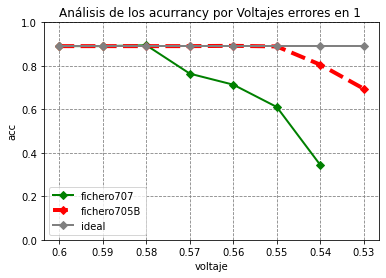

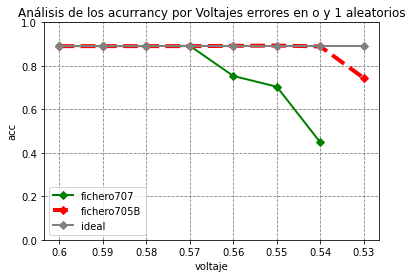

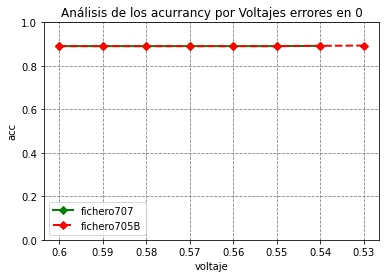

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

fig, ax = plt.subplots()



x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]



x_values = range(len(x))


y =[0.890666663646698, 0.890666663646698, 0.8946666717529297, 0.7639999985694885, 0.7133333086967468,  0.6106666922569275, 0.3440000116825104, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero

z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.8893333077430725, 0.8053333163261414, 0.6946666836738586]
plt.plot(z, label='fichero705B', color='red', ls='--', lw='4', marker='D', markersize='5', )# hacer un plot para cada fichero

i = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698]
plt.plot(i, label='ideal', color='grey', ls='-', lw='2', marker='D', markersize='5', )

plt.title("Análisis de los acurrancy por Voltajes errores en 1 ")
plt.xlabel('voltaje')
plt.ylabel('acc')
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')



fig, ax = plt.subplots()

x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]
x_values = range(len(x))

y =[0.890666663646698, 0.890666663646698,0.890666663646698, 0.8920000195503235, 0.753333330154419, 0.7039999961853027, 0.448000013828277, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.8933333158493042, 0.8893333077430725, 0.7440000176429749]
plt.plot(z, label='fichero705B', color='red', ls='--', lw='4', marker='D', markersize='5', )# hacer un plot para cada fichero

i = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698]
plt.plot(i, label='ideal', color='grey', ls='-', lw='2', marker='D', markersize='5', )


plt.title("Análisis de los acurrancy por Voltajes errores en o y 1 aleatorios")
plt.xlabel('voltaje')
plt.ylabel('acc')                     
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')




fig, ax = plt.subplots()
x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]
x_values = range(len(x))
y = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.8933333158493042]
plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero

plt.title("Análisis de los acurrancy por Voltajes errores en 0")
plt.xlabel('voltaje')
plt.ylabel('acc')
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')





plt.show()

# Gráficas para los errores en los pesos segunda parte del buffer

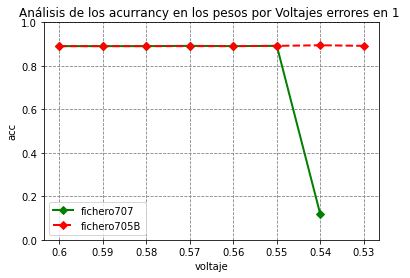

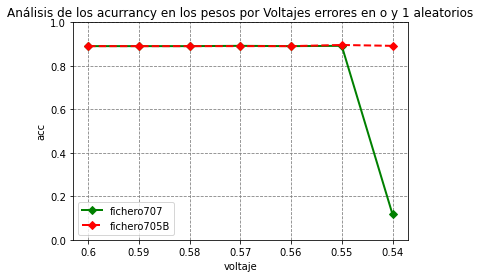

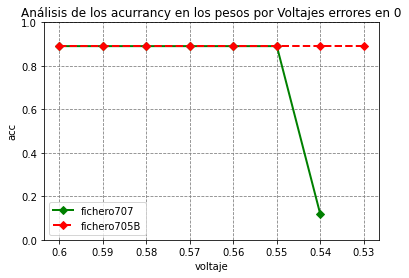

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

fig, ax = plt.subplots()



x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]


x_values = range(len(x))


y =[0.890666663646698, 0.890666663646698, 0.890666663646698,0.8920000195503235,0.89066666364669800, 0.8920000195503235, 0.11733333021402359, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.8946666717529297,  0.8920000195503235  ]

plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero

plt.title("Análisis de los acurrancy en los pesos por Voltajes errores en 1 ")
plt.xlabel('voltaje')
plt.ylabel('acc')
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')



fig, ax = plt.subplots()

x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]
x_values = range(len(x))

y =[0.890666663646698, 0.890666663646698,0.890666663646698, 0.8920000195503235, 0.89066666364669800, 0.8920000195503235, 0.11733333021402359, None]
plt.xticks(x_values, x)
ylim(0, 1)

plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8960000276565552,  0.8920000195503235]

plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
escala = 0.890666663646698

plt.title("Análisis de los acurrancy en los pesos por Voltajes errores en o y 1 aleatorios")
plt.xlabel('voltaje')
plt.ylabel('acc')                     
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')


fig, ax = plt.subplots()
x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]
x_values = range(len(x))
y = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.11733333021402359, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698]
plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero

plt.title("Análisis de los acurrancy en los pesos por Voltajes errores en 0")
plt.xlabel('voltaje')
plt.ylabel('acc')
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')





plt.show()

# Gráficas para los errores en los pesos y activaciones primera parte del buffer

In [21]:
from FileAnalize import  load_file
print(load_file('Data/Fault Characterization/Acc_w_55'))
#save_file(Accs,'Data/Fault Characterization/Accs'

[0.890666663646698, 0.6066666841506958, 0.6986666917800903]


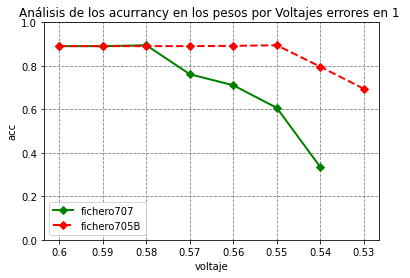

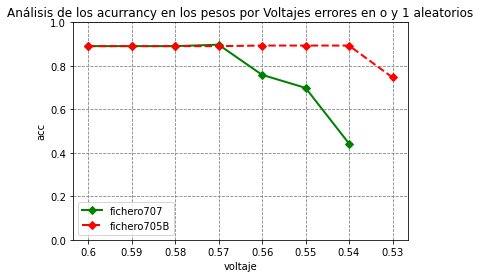

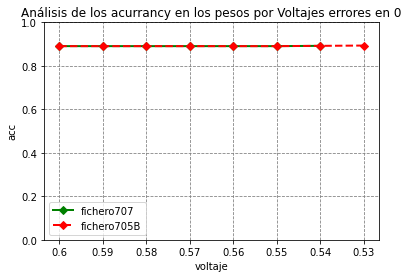

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

fig, ax = plt.subplots()



x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]


x_values = range(len(x))


y =[0.890666663646698, 0.890666663646698, 0.8946666717529297,  0.7613333463668823, 0.7106666564941406, 0.6066666841506958, 0.3346666693687439, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, 0.8946666717529297, 0.7960000038146973, 0.6946666836738586]

plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero

plt.title("Análisis de los acurrancy en los pesos por Voltajes errores en 1 ")
plt.xlabel('voltaje')
plt.ylabel('acc')
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')



fig, ax = plt.subplots()

x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]
x_values = range(len(x))

y =[0.890666663646698, 0.890666663646698,0.890666663646698,0.8973333239555359, 0.7586666941642761,0.6986666917800903, 0.4426666796207428, None]
plt.xticks(x_values, x)
ylim(0, 1)

plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698, 0.890666663646698,0.890666663646698, 0.890666663646698, 0.8933333158493042, 0.8933333158493042, 0.8933333158493042, 0.746666669845581]

plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero


plt.title("Análisis de los acurrancy en los pesos por Voltajes errores en o y 1 aleatorios")
plt.xlabel('voltaje')
plt.ylabel('acc')                     
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')


fig, ax = plt.subplots()
x= [0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53]
x_values = range(len(x))
y = [0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.890666663646698, 0.8920000195503235, None]
plt.xticks(x_values, x)
ylim(0, 1)
plt.plot(y, label='fichero707', color='green', ls='-', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero
z = [0.890666663646698,0.890666663646698,0.890666663646698, 0.890666663646698,0.890666663646698,0.890666663646698, 0.8920000195503235, 0.8933333158493042]
plt.plot(z, label='fichero705B', color='red', ls='--', lw='2', marker='D', markersize='5', )# hacer un plot para cada fichero

plt.title("Análisis de los acurrancy en los pesos por Voltajes errores en 0")
plt.xlabel('voltaje')
plt.ylabel('acc')
plt.legend(loc=3)
ax.grid( color = 'gray', linestyle = 'dashed')





plt.show()

prueba_recibiendo los datos

In [78]:
## from copy import deepcopy
#from Stats import CheckAccuracyAndLoss
#from Simulation import save_obj, load_obj
#from FileAnalize import analize_fil
#from datetime import datetime
#import itertools
#from Training import GetDatasets
#import numpy as np
#import os
# 
#cwd = os.getcwd()
#wgt_dir = os.path.join(cwd, 'Data')
#wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
#wgt_dir = os.path.join(wgt_dir, 'AlexNet')
#wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
#wgt_dir = os.path.join(wgt_dir,'Weights')
#    
#
#trainBatchSize = testBatchSize = 16
#_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)
#
#
#
## Porciones del buffer  a probar
##Accs     = {0.0:[],0.00001:[],0.00005:[],0.0001:[],0.1:[]}
##Loss     = {0.0:[],0.00001:[],0.00005:[],0.0001:[],0.1:[]}
#
#
#network_size   = 4646400   # Tamaño del buffer (en bits)
#
#
#num_of_samples = 10      # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
##buffer= (analize_file(('Data/VC'), 4646400))
##print (buffer)
#address_with_errors,  locs= (analize_fil(('Data/VC'), 4646400))
#
#for index in range(0,num_of_samples):
#    #address_with_errors = np.reshape(buffer,(-1,16))
#     
#    #address_with_errors = ["".join(i) for i in address_with_errors[0:10]]
#    print(address_with_errors)
#           
#    #error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]
#    error_mask = address_with_errors
#    print(error_mask)
#    #locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
#        
#    #print(type(locs))
#    #locs = address_with_errors
#    print(locs)
#
#    
#    
#              
#    #del address_with_errors
#           
#    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
#                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
#                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False, 
#                                            faulty_addresses = locs, masked_faults = error_mask)
#    
#                                 
#       
#       
#      
#        
#    #Accs[Enumber].append(acc)
#    #Loss[Enumber].append(loss)
#    print(loss)
#    print(acc)
#print(str(n_bits_total)+' completada: ', datetime.now().strftime("%H:%M:%S"))
##save_obj(Accs,'Data/Errors/AlexNet/Colorectal Dataset/Accs')
##save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

[['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ...
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']]
[['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ...
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']
 ['x' 'x' 'x' ... 'x' 'x' 'x']]
(array([  4141,   4141,   4181, ..., 288944, 289380, 289380], dtype=int64), array([1, 9, 1, ..., 9, 1, 9], dtype=int64))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

pasando_1and_0

In [57]:
Accs

NameError: name 'Accs' is not defined

In [ ]:
 Loss

4) Error Injection

Medición del efecto de las fallas en las activaciones

In [ ]:
#from copy import deepcopy
#from Stats import CheckAccuracyAndLoss
#from Simulation import save_obj, load_obj
#from datetime import datetime
#import itertools
#
#trainBatchSize = testBatchSize = 16
#_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)
#
#
## Porciones del buffer con fallos a probar
#Accs     = {0.00001:[],0.00005:[],0.0001:[]}
#Loss     = {0.00001:[],0.00005:[],0.0001:[]}
#
## Tamaño del buffer (en bits)
#network_size   = 290400*16
## Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
#num_of_samples = 10
#for Enumber in Accs:
#    n_bits_fails = np.ceil(Enumber*network_size).astype(int)    #numero de bits con fallos
#    errors       = np.random.randint(0,2,n_bits_fails)          #tipo de fallos (0 o 1)
#    # crear una representacion del buffer x indica celda inafectada, 1 celda con valor 1 permanente y 0 celda con valor 0 perm.
#    buffer       = np.array(['x']*(network_size-n_bits_fails))  
#    buffer       = np.concatenate([buffer,errors])
#    for index in range(0,num_of_samples):
#        np.random.shuffle(buffer)  # crear un orden aleatorio de los errores en el buffer
#        # en las siguientes 4 lineas se obtienen las direcciones de los errores y los tipos de error
#        address_with_errors = np.reshape(buffer,(-1,16))
#        address_with_errors = ["".join(i) for i in address_with_errors]
#        error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]
#        locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
#        del address_with_errors
#        #ahora se obtiene el loss y acc para esta configuracion.
#        loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
#                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
#                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
#                                            faulty_addresses = locs, masked_faults = error_mask)
#        #Accs[Enumber].append(acc)
#        #Loss[Enumber].append(loss)
#    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
#   # save_obj(Accs,'Data/Errors/AlexNet/Colorectal Dataset/Uniform distribution/Accs')
#    #save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Uniform distribution/Loss')
#   

El resultado es un diccionario con accuracy y loss para cada muestra, por ejemplo, el caso de 0.0001 del buffer con fallos la accuracy ronda entre el 71 y 76% en los 10 casos aleatorios probados.

In [ ]:
#Accs

In [ ]:
#Loss

corri con otros datos del buffer

In [ ]:
#import pickle
#Accs= ('Data/Errors/AlexNet/Colorectal Dataset/Uniform distribution/Accs.pkl')
#def recupera_archivo_pickle(Accs): 
    #with open(Accs,'rb' ) as f :
        #return pickle.load(f)

In [ ]:
#resultado =  recupera_archivo_pickle(Accs)
#print(resultado)

In [ ]:
#import os
#import pickle
#
#
#def leer_archivo_binario(results_dir):
#    if os.path.exists(results_dir):
#        if os.path.isfile(results_dir):
#            with open(results_dir,'rb' ) as f :
#                return pickle.load(f)
#        else: 
#                return None
#            
            

Sin injeccion de errores

In [8]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import os

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)



# Porciones del buffer  a probar
#Accs     = {0.0:[],0.00001:[],0.00005:[],0.0001:[],0.1:[]}
#Loss     = {0.0:[],0.00001:[],0.00005:[],0.0001:[],0.1:[]}


network_size   = 16777216  # Tamaño del buffer (en bits)
num_of_samples = 10       # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
#for Enumber in Accs:
    
n_bits_total = np.ceil(network_size).astype(int)    #numero de bits totales
print(n_bits_total)
buffer = np.array(['x']*(network_size))
print(buffer)
for index in range(0,num_of_samples):
        
    loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = False)
       
    
    print(acc)
    print(loss)
      
        
    #Accs.append(acc)
print(str(n_bits_total)+' completada: ', datetime.now().strftime("%H:%M:%S"))
#save_obj(Accs_s,'Data/Fault Characterization/Accs_')
#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

16777216
['x' 'x' 'x' ... 'x' 'x' 'x']
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
0.890666663646698
0.3125045895576477
16777216 completada:  15:36:35


NameError: name 'Accs_s' is not defined

Medición del efecto de las fallas en los pesos